### Importing Libraries & Helper Functions

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from utils import *
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, LambdaCallback

%matplotlib inline
tf.logging.set_verbosity(tf.logging.ERROR)

print('Libraries imported.')

Libraries imported.


### Importing the Data

In [23]:
df=pd.read_csv('data.csv',names=column_names)
df.head()

,serial,date,age,distance,stores,latitude,longitude,price
0,0,2009,21,9,6,84,121,14264
1,1,2007,4,2,3,86,121,12032
2,2,2016,18,3,7,90,120,13560
3,3,2002,13,2,2,80,128,12029
4,4,2014,25,5,8,81,122,14157


### Check Missing Data

In [24]:
df.isna().sum()

serial       0
date         0
age          0
distance     0
stores       0
latitude     0
longitude    0
price        0
dtype: int64

### Data Normalization

In [25]:
df=df.iloc[:,1:]
df_norm = (df-df.mean())/df.std()
df_norm.head()

,date,age,distance,stores,latitude,longitude,price
0,0.015978,0.181384,1.257002,0.345224,-0.307212,-1.260799,0.350088
1,-0.350485,-1.319118,-0.930610,-0.609312,0.325301,-1.260799,-1.836486
2,1.298598,-0.083410,-0.618094,0.663402,1.590328,-1.576456,-0.339584
3,-1.266643,-0.524735,-0.930610,-0.927491,-1.572238,0.948803,-1.839425
4,0.932135,0.534444,0.006938,0.981581,-1.255981,-0.945141,0.245266


### we need to convert the predicted values back to the original distribution if we want predicted prices.

In [26]:
y_mean=df['price'].mean()
y_std=df['price'].std()

def convert_label_value(pred):
    return int(pred*y_std+y_mean)

print(convert_label_value(0.350088))


14263


### Selecting Features

In [27]:
x = df_norm.iloc[:,:6]
x.head()

,date,age,distance,stores,latitude,longitude
0,0.015978,0.181384,1.257002,0.345224,-0.307212,-1.260799
1,-0.350485,-1.319118,-0.930610,-0.609312,0.325301,-1.260799
2,1.298598,-0.083410,-0.618094,0.663402,1.590328,-1.576456
3,-1.266643,-0.524735,-0.930610,-0.927491,-1.572238,0.948803
4,0.932135,0.534444,0.006938,0.981581,-1.255981,-0.945141


### Select Labels

In [28]:
y=df_norm.iloc[:,-1]
y.head()

0    0.350088
1   -1.836486
2   -0.339584
3   -1.839425
4    0.245266
Name: price, dtype: float64

### We will need to extract just the numeric values for the features and labels

In [29]:
x_arr=x.values
y_arr=y.values
print(x_arr.shape)
print(y_arr.shape)

(5000, 6)
(5000,)


### Train and Test Split

In [30]:
x_train,x_test,y_train,y_test=train_test_split(x_arr,y_arr,test_size=0.05)
print(x_train.shape,y_train.shape)
print(x_test.shape,y_test.shape)

(4750, 6) (4750,)
(250, 6) (250,)


### Creating the Model

In [31]:
def get_model():
    model=Sequential([
        Dense(10,input_shape=(6,),activation='relu'),
        Dense(20,activation='relu'),
        Dense(5,activation='relu'),
        Dense(1)
    ])
    model.compile(
    loss='mse',
    optimizer='adam'
    )
    return model
get_model().summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 10)                70        
_________________________________________________________________
dense_9 (Dense)              (None, 20)                220       
_________________________________________________________________
dense_10 (Dense)             (None, 5)                 105       
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 6         
Total params: 401
Trainable params: 401
Non-trainable params: 0
_________________________________________________________________


### Model Training

In [36]:
es_cb=EarlyStopping(monitor='val_loss',patience=5)

model=get_model()
pred_on_untrained=model.predict(x_test)
history=model.fit(
x_train,y_train,
validation_data=(x_test,y_test),
epochs=100,
callbacks=[es_cb]
)

Train on 4750 samples, validate on 250 samples
Epoch 1/100
4750/4750 [==============================] - 1s 127us/sample - loss: 0.7698 - val_loss: 0.4329
Epoch 2/100
4750/4750 [==============================] - 0s 42us/sample - loss: 0.2887 - val_loss: 0.2124
Epoch 3/100
4750/4750 [==============================] - 0s 42us/sample - loss: 0.1887 - val_loss: 0.1839
Epoch 4/100
4750/4750 [==============================] - 0s 39us/sample - loss: 0.1746 - val_loss: 0.1795
Epoch 5/100
4750/4750 [==============================] - 0s 39us/sample - loss: 0.1684 - val_loss: 0.1734
Epoch 6/100
4750/4750 [==============================] - 0s 39us/sample - loss: 0.1649 - val_loss: 0.1735
Epoch 7/100
4750/4750 [==============================] - 0s 40us/sample - loss: 0.1618 - val_loss: 0.1666
Epoch 8/100
4750/4750 [==============================] - 0s 40us/sample - loss: 0.1608 - val_loss: 0.1644
Epoch 9/100
4750/4750 [==============================] - 0s 41us/sample - loss: 0.1588 - val_loss: 0.167

### Plot Training and Validation Loss

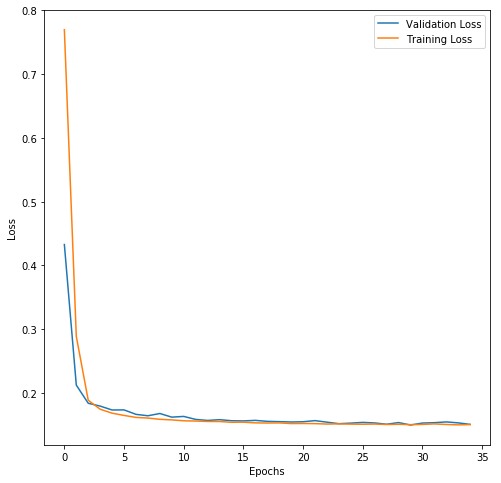

In [37]:
plot_loss(history)

### Plot Raw Predictions

Let's use the `compare_predictions` helper function to compare predictions from the model when it was untrained and when it was trained.

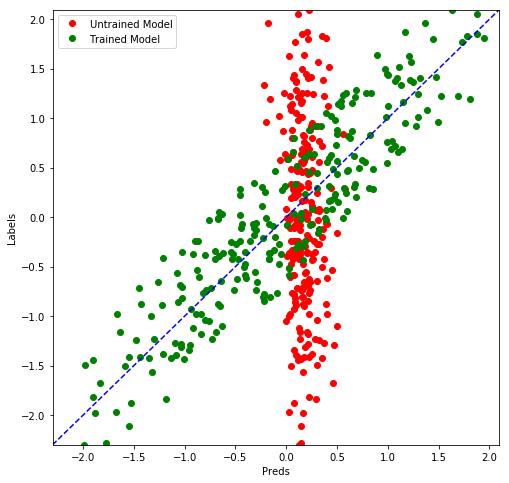

In [38]:
pred_on_trained=model.predict(x_test)
compare_predictions(pred_on_untrained,pred_on_trained,y_test)

### Plot Price Predictions

The plot for price predictions and raw predictions will look the same with just one difference: The x and y axis scale is changed.

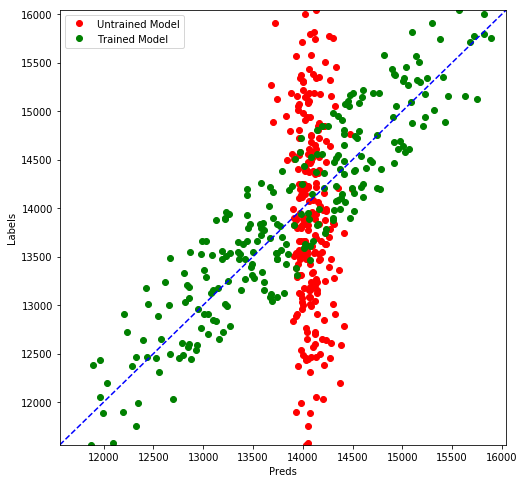

In [39]:
price_untrained=[convert_label_value(y) for y in pred_on_untrained]
price_trained=[convert_label_value(y) for y in pred_on_trained]
price_test=[convert_label_value(y)for y in y_test]

compare_predictions(price_untrained,price_trained,price_test)